# Fisher-like Equation

This notebook implements the PIGP and PSGP experiments involving the Fisher-like equation from Section 4.2 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [3]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ["JAX_PLATFORM_NAME"] = "cpu"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [5]:
import jax.numpy as jnp
from jax import config, random

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys

sys.path.append("../../")

import jax_pigp
from jax_pigp.utility_fns import (
    softplus,
    generate_params,
    PARAM_OPTIONS_DICT as param_gen_options,
)
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True)

### Specify settings of the experiments

Ensure that this cell is tagged as "parameters" if using [papermill](https://papermill.readthedocs.io/en/latest/)

In [3]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 3001

# whether to use a psgp or pigp, i.e. whether to incorporate symmetry information
# into the inference or not
GP_TYPE = "psgp"
assert GP_TYPE in ["pigp", "psgp"]

# Number of PDE/ISC collocation points to use for inference
N_COLLOCATION_POINTS: int = 128  # values 16, 32, 64, 128 considered in paper
Nu: int = 0  # no u-space observations used in this experiment
Nf: int = N_COLLOCATION_POINTS
# for pigp, no ISC data is incorporated so Ng = 0 in this case
Ng: int = N_COLLOCATION_POINTS if GP_TYPE == "psgp" else 0

# number of sub-linear differential operators required in specification
# of F, the algebraic representation of the PDE. In this case, we have
# two: Lf0 and Lf1, which are specified below
N_Lf: int = 2

# formula for calculating the dimensionality of the latent vector h
Nh: int = Nu + N_Lf * Nf + Ng
## Note: see Section 3.1 of the manuscript for a description of h

# path to subdirectory in ./data where fisher-like equation data is saved
data_save_dir: str = f"fisherLikeEquation"
data_save_dir_full = os.path.join("data", data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 2

# initial value for std of noise levels in each space
NOISE_INIT: float = 0.1

# we use softplus transformation to ensure noise values are positive
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = False

# options for model training
N_TRAIN_STEPS: int = 100000
N_RESTARTS: int = 1
LR_INIT: float = 1e-4
VERBOSE: bool = True

### Specify mean and kernel functions

For the PIGP and PSGP models. The mean and kernel are designed such that the GP exactly satisfies the initial condition at $t=0$ and spatial boundary conditions at $x=-5/5$. In this case the true solution is known, and we extract these conditions from the solution

In [4]:
# lower and upper boundaries of the spatio-temporal domain
lb = jnp.array([-5.0, 0.0])
ub = jnp.array([5.0, 10.0])
domain_length = ub[0] - lb[0]

# true solution function
u_true = lambda x, t: 0.5 - 0.5 * jnp.tanh(
    1.0 + 0.25 * jnp.sqrt(2) * (x - t / (jnp.sqrt(2)))
)

# initial condition
t0_fn = lambda x: u_true(x, lb[1])

# lower spatial boundary condition
lb_fn = lambda t: u_true(lb[0], t)

# lower spatial boundary condition
ub_fn = lambda t: u_true(ub[0], t)

# corner values needed for defining mean_fn
u_lb_t0 = lb_fn(lb[1])
u_ub_t0 = ub_fn(lb[1])


def mean_fn(p_: dict, loc: Array):
    x, t = loc
    return (
        t0_fn(x)
        + (ub_fn(t) - u_ub_t0) * ((x + ub[0]) / domain_length)
        + (lb_fn(t) - u_lb_t0) * (-lb[0] - x) / domain_length
    )


base_kernel = jax_pigp.kernels.rational_quadratic


def phi(loc: Array):
    x, t = loc
    return ((ub[0] - x) * (x - lb[0]) * t) / 250.0


def kernel_fn(params: dict, loc1: Array, loc2: Array):

    base_kernel_val = base_kernel(params, loc1, loc2)

    adjust_val = phi(loc1) * phi(loc2)

    return (adjust_val * base_kernel_val).squeeze()

### Specify linear differential operators

Recall that the Fisher-like PDE considered in the paper takes the form

$$PDE[u] =  \frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} - u^2(1-u) = f = 0$$

In shorthand notation (see Eq. (5) of the manuscript), the PDE reads

$$PDE[u] = u_{t} - u_{xx}- u^2(1-u) = f = 0.$$

Similarly, the ISC (see Eq. (24)) reads

$$ISC[u] = u_{t} + \frac{1}{\sqrt{2}} u_{x} = g = 0.$$

Consider the following two functions, each of which is found by applying a linear operator to $u$:

\begin{align}
d_0 &= \mathcal{L}_0^f u = u \\
d_1 &= \mathcal{L}_1^f u = u_{t} - u_{xx}
\end{align}

We can use these functions to represent the PDE in algebraic form as

\begin{equation}
F(d_0, d_1) = d_1 - d_0^2(1-d_0) = 0.
\end{equation}

See Section 2.2 of the manuscript for further details of the functions $d_0$, $d_1$ and $F$. In particular, note the difference here to Eq.(6) of the paper, as we have combined $u_t$ and $u_{xx}$ into a single operator rather than considering them separately.

The function $F$ above allows us to specify a virtual liklihood in the GP model for the PDE collocation points (see Eq. (18)).


##### Implementation: 

* $d_{0}$ is returned by calling the ``apply_Lf0`` function defined below, with equivalent functions defined for $d_1$ and $g$.

* $F(d_0, d_1)$ is implemented in the function ``F``



In [5]:
def apply_Lf0(fn: Callable, argnum: int = 1):
    r"""
    In this Lf0 is the identity transformation
    """
    return fn


def apply_Lf1(fn: Callable, argnum: int = 1):
    r"""
    Applies Lf1 to given input input fn,
    evaluated at specified argnum
    """

    # the Jacobian and Hessian functions
    Jfn, Hfn = jac_hess(fn, argnum)

    def Lf1(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal
        ## value in loc1 / loc2

        _, ut_val = Jfn(params, loc1, *loc2)

        uxx_val = Hfn(params, loc1, *loc2)[0, 0]

        return ut_val - uxx_val

    return Lf1


def apply_ISC(fn: Callable, argnum: int = 1):
    r"""
    Appies ISC to given input input fn,
    evaluated at specified argnum
    """
    # the Jacobian and Hessian functions
    Jfn, _ = jac_hess(fn, argnum)

    sqrt_2_inv = 1.0 / jnp.sqrt(2.0)

    def ISC(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal
        ## value in loc1 / loc2

        ux_val, ut_val = Jfn(params, loc1, *loc2)

        return ut_val + sqrt_2_inv * ux_val

    return ISC


linear_operators = [apply_Lf0, apply_Lf1, apply_ISC]

## Note : f-space (i.e. PDE space) operators must always come before
## the g-space ISC operator get_ISC in linear_operators above

## Note: no u-space observations are used in this example. If
## u-space data is available, we define a dummy get_Lu function
## which is just the identity transformation. This function
## must be included before get_Lf0 when specifying linear_operators

####################################################################
# we need to specify which inputs to evaluate the above differential
# operators on.
# Below, 0 represents f-space (i.e. PDE) observations,
# while 1 represents g-space (i.e. ISC) observations.
# Lf0 and Lf1 correspond to Xf inputs, so their corresponding value
# in Xtrain_indices is 0. The ISC corresponds to Xg inputs, so it
# gets mapped to
Xtrain_indices = [0, 0, 1]

## Note: If we had u-space (i.e. solution space) observations, then
## they have be be labelled with index 0. f-space observations would then be
## labelled with 1, while any g-space observations would be labelled 2


def F(params: dict, d: Array):
    r"""
    Algebraic representation of the PDE
    """
    # N_Lf is equal to the length of the vector d here
    d0, d1 = d
    return d1 - (d0**2) * (1.0 - d0)

### Store settings

Store optimisation options in a dictionary

In [6]:
opt_options = {}
opt_options["n_steps"] = N_TRAIN_STEPS
opt_options["n_restarts"] = N_RESTARTS
opt_options["lr"] = LR_INIT
opt_options["verbose"] = VERBOSE
opt_options["noise_transform"] = NOISE_TRANSFORM

Specify parameter initialisation function

In [7]:
param_gen_options["ls_bounds"] = [0.5, 5.0]
param_gen_options["amp_bounds"] = [1.0, 10.0]
param_gen_options["alpha_bounds"] = [1.0, 10.0]
param_gen_options["input_dim"] = INPUT_DIM
# each function space (u/f/g spaces) gets its own noise level
param_gen_options["noise_std_init"] = [NOISE_INIT]*3
param_gen_options["noise_transform"] = NOISE_TRANSFORM
param_gen_options["nonlinear"] = True
param_gen_options["Nh"] = Nh

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [8]:
results_save_dir = os.path.join("results", data_save_dir, f"{GP_TYPE}_Nf_{Nf}_Ng_{Ng}")
if not os.path.isdir(results_save_dir):
    os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [9]:
train_data, test_data = load_data_nonlinear(data_save_dir_full, Nu, Nf, Ng)

Check shapes of train and test data

In [10]:
test_data.us.shape, [X.shape for X in train_data.Xtrain]

((8000, 1), [(128, 2), (128, 2)])

### Initialise PIGP model

In [11]:
fisher_like_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(
    kernel_fn, linear_operators, Xtrain_indices
)
fisher_like_mean_fns = jax_pigp.interdomain_moments.InterdomainMeanFns(
    mean_fn, linear_operators, Xtrain_indices
)

gp_model = jax_pigp.models.PSGP(fisher_like_kernel_fns, fisher_like_mean_fns, F, N_Lf)

### Initialise learner for model training

In [12]:
obj_fn_train = lambda params: -gp_model.elbo(params, train_data)

gp_learner = jax_pigp.optimisers.AdamLearner(
    obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL)
)

In [13]:
obj_fn_train(gp_learner.params)

Array(4453822.69151252, dtype=float64)

Initial parameter values  

In [14]:
print_param_values(gp_learner.params, opt_options)

amp: [9.72570182]
ls: [2.70537882 1.37054593]
alpha: [9.51654614]
noise_std: [0.1 0.1 0.1]


Objective function value for initial parameters

In [15]:
gp_model.elbo(gp_learner.params, train_data)

Array(-4453822.69151252, dtype=float64)

Gradient of the objective function wrt to initial parameters

In [16]:
# gp_learner.grad_obj_fn(gp_learner.params)

## Training 

[JIT compile](https://jax.readthedocs.io/en/latest/jit-compilation.html) the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [17]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [18]:
print(
    f"gp_type={GP_TYPE}, Nf={Nf}, Ng={Ng}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n"
)
gp_learner.train_with_restarts(
    opt_options["n_steps"],
    opt_options["n_restarts"],
    print_progress=opt_options["verbose"],
)

gp_type=psgp, Nf=128, Ng=128, n_steps=100000, n_restarts=1

Restart 0: beginning training for 100000 steps
(0): 731235.6743, noise_std_vals = [1.00e-01,1.00e-01,1.00e-01]
(4000): 47618.7251, noise_std_vals = [1.00e-01,1.24e-01,1.37e-01]
(8000): 8586.2186, noise_std_vals = [1.00e-01,1.44e-01,1.83e-01]
(12000): 1918.4077, noise_std_vals = [1.00e-01,1.68e-01,2.36e-01]
(16000): 471.0652, noise_std_vals = [1.00e-01,2.00e-01,2.65e-01]
(20000): 67.6515, noise_std_vals = [1.00e-01,2.37e-01,1.94e-01]
(24000): -75.0057, noise_std_vals = [1.00e-01,2.53e-01,1.31e-01]
(28000): -181.3467, noise_std_vals = [1.00e-01,1.83e-01,8.90e-02]
(32000): -286.5174, noise_std_vals = [1.00e-01,1.25e-01,5.99e-02]
(36000): -389.8090, noise_std_vals = [1.00e-01,8.52e-02,4.00e-02]
(40000): -492.7291, noise_std_vals = [1.00e-01,5.81e-02,2.67e-02]
(44000): -594.4977, noise_std_vals = [1.00e-01,3.94e-02,1.79e-02]
(48000): -692.9408, noise_std_vals = [1.00e-01,2.67e-02,1.20e-02]
(52000): -786.7931, noise_std_vals = [1.00

Uncomment below to continue training from existing parameter values:

In [26]:
# gp_learner.train(opt_options["n_steps"])

### Plot training results

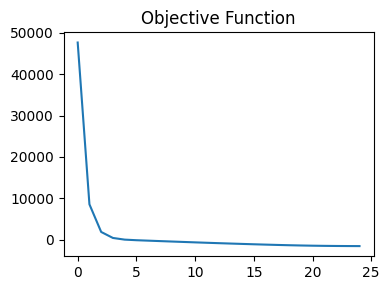

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=ONE_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list) * 0.05)

plot_lc(ax, gp_learner.obj_list[begin_at:], "Objective Function")

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "learningCurves.pdf"))

### Final trained parameter values

In [21]:
# extract final trained parameter values
try:
    trained_params = gp_learner.params_best.copy()
    print(f'set trained_params to gp_learner.params_best\n')
except:
    trained_params = gp_learner.params.copy()
    print(f'set trained_params to gp_learner.params\n')

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
param_save_path = os.path.join(results_save_dir, "trained_params.pkl")
with open(param_save_path, "wb") as fp:
    pickle.dump(trained_params, fp)

set trained_params to gp_learner.params_best

alpha: [1.58114601]
amp: [0.298247]
ls: [4.23175519 5.767703  ]
noise_std: [1.00000000e-01 2.05278837e-04 9.93140214e-05]


Can load pre-trained parameters by uncommenting the below

In [22]:
# with open(param_save_path, 'rb') as f:
#     trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [23]:
# posterior mean and covariance over test points
print(
    f"Posterior results for {GP_TYPE}, Nf={Nf}, Ng={Ng}, Ns={test_data.Xs.shape[0]}"
)
# posterior mean and covariance over test outputs us
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)

# standard deviation of prediction at each test point
s = jnp.diag(Sigma) ** 0.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, "u_pred.npy"), mu)
    jnp.save(os.path.join(results_save_dir, "s_pred.npy"), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f"mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}")
savetxt(
    os.path.join(results_save_dir, "mean_loss.txt"), abs_losses.mean().reshape(-1, 1)
)

Posterior results for psgp, Nf=128, Ng=128, Ns=8000
mean/max loss: 3.328943e-05/2.408e-04


### Plots of posterior prediction

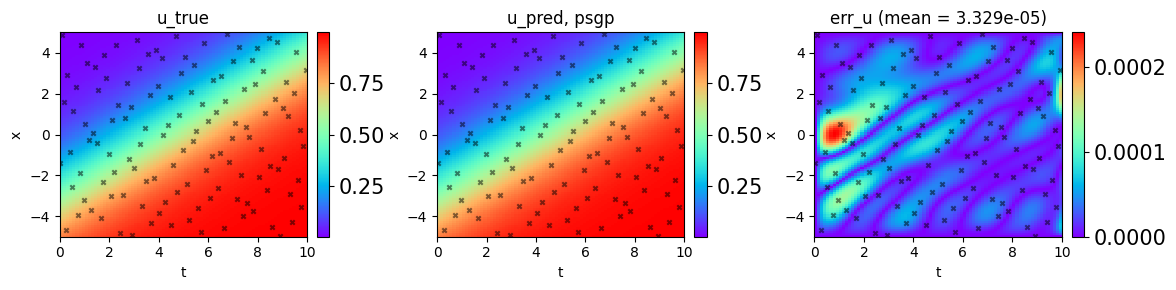

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=THREE_COLUMN_FIGSIZE)

Nx = len(jnp.unique(test_data.Xs[:, 0]))
Nt = len(jnp.unique(test_data.Xs[:, 1]))

Xu = None
Xf = train_data.Xtrain[0]

make_heatmap_fisher = lambda ax, output, title=None: make_heatmap(
    fig, ax, output.reshape(Nt, Nx).T, test_data, Xu, Xf, title
)

make_heatmap_fisher(axes[0], test_data.us, title="u_true")
make_heatmap_fisher(axes[1], mu, title=f"u_pred, {GP_TYPE}")
make_heatmap_fisher(
    axes[2], abs_losses, title=f"err_u (mean = {abs_losses.mean():.3e})"
)

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, "posteriorPrediction.pdf"))